<a href="https://colab.research.google.com/github/Lindronics/honours_project/blob/master/notebooks/classification/animals/Animal_classifier_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Animal classifier

## Setup and imports



In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
!rm -rf /content/*
!wget --no-check-certificate -O animals_train_cleaned.zip "https://onedrive.live.com/download?cid=5691066189D062AB&resid=5691066189D062AB%21228385&authkey=AJ2672WIbXEi1qw"
!wget --no-check-certificate -O animals_test_cleaned.zip "https://onedrive.live.com/download?cid=5691066189D062AB&resid=5691066189D062AB%21228382&authkey=ANMdlayES2NsGVE"
print("=> Fetched data")
!unzip -q animals_train_cleaned.zip
print("=> Unzipped train data")
!unzip -q animals_test_cleaned.zip
print("=> Unzipped test data")
!mv animals_train_clean animals_train_cleaned

--2020-02-27 09:39:07--  https://onedrive.live.com/download?cid=5691066189D062AB&resid=5691066189D062AB%21228385&authkey=AJ2672WIbXEi1qw
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://6xqbtg.am.files.1drv.com/y4moQ1b_UJBdullK13IK1gZ2u0z9UP223sxdfpw3RkmMz5poNRP-IKxRW-ueaz4WWideVFf3kVC18LpIPllklPTH2-w7q9T9AQSW84somNkXf819oJgnNVhvTQF_wr8_al89NBt9fxO39oo3xUz-Daj96gjYNPktCdvKY14UIsUWcik2wv3FQP8YrIhoytm_8uCnocGfqdaz_8Sb85eh8wXCQ/animals_train_cleaned.zip?download&psid=1 [following]
--2020-02-27 09:39:13--  https://6xqbtg.am.files.1drv.com/y4moQ1b_UJBdullK13IK1gZ2u0z9UP223sxdfpw3RkmMz5poNRP-IKxRW-ueaz4WWideVFf3kVC18LpIPllklPTH2-w7q9T9AQSW84somNkXf819oJgnNVhvTQF_wr8_al89NBt9fxO39oo3xUz-Daj96gjYNPktCdvKY14UIsUWcik2wv3FQP8YrIhoytm_8uCnocGfqdaz_8Sb85eh8wXCQ/animals_train_cleaned.zip?download&psid=1
Resolving 6xqbtg.am.files.1drv.c

In [0]:
!git clone https://github.com/Lindronics/honours_project

Cloning into 'honours_project'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 880 (delta 15), reused 27 (delta 10), pack-reused 847
Receiving objects: 100% (880/880), 50.92 MiB | 40.80 MiB/s, done.
Resolving deltas: 100% (430/430), done.


In [0]:
!rm -rf animals_train_cleaned/images_augmented
!python honours_project/preprocessing/augment.py -d animals_train_cleaned/images animals_train_cleaned/images_augmented animals_train_cleaned/labels.txt 5

Dataset composition:
 - alpaca: 	304
 - ugly-duck: 	141
 - evil-chicken: 	129
 - pretty-chicken: 	58
 - pony: 	211
 - cat: 	149
 - chicken: 	148
 - goose: 	125
1265 items total.
100% 1265/1265 [03:22<00:00,  5.40it/s]

Finished.


In [0]:
!rm -rf animals_test_cleaned/images_augmented
!python honours_project/preprocessing/augment.py -d animals_test_cleaned/images animals_test_cleaned/images_augmented animals_test_cleaned/labels.txt 2

Dataset composition:
 - alpaca: 	45
 - ugly-duck: 	24
 - evil-chicken: 	17
 - pretty-chicken: 	29
 - pony: 	28
 - cat: 	56
 - chicken: 	78
 - goose: 	19
296 items total.
100% 296/296 [00:26<00:00,  7.72it/s]

Finished.


In [0]:
# from honours_project.preprocessing.generate_labels import generate_labels, write_labels

# write_labels(generate_labels(lambda _: True, "animals_train_cleaned/images"), "labels_train.txt")
# write_labels(generate_labels(lambda _: True, "animals_test_cleaned/images"), "labels_test.txt")


from honours_project.preprocessing.generate_labels import generate_labels, write_labels

# Only chicken, alpaca
f = lambda x: x.split("_")[0] not in ["chicken"]
write_labels(generate_labels(f, "animals_train_cleaned/images_augmented", channel_prefix=False), "labels_train.txt")
write_labels(generate_labels(f, "animals_test_cleaned/images_augmented", channel_prefix=False), "labels_test.txt")

Dataset composition:
 - alpaca: 	1520
 - ugly-duck: 	1520
 - evil-chicken: 	1520
 - pretty-chicken: 	1520
 - pony: 	1520
 - cat: 	1520
 - chicken: 	0
 - goose: 	1520
10640 items total.
Dataset composition:
 - alpaca: 	156
 - ugly-duck: 	156
 - evil-chicken: 	156
 - pretty-chicken: 	156
 - pony: 	156
 - cat: 	156
 - chicken: 	0
 - goose: 	156
1092 items total.


In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns; sns.set()
import os
from os import listdir
from os.path import isdir, join
import shutil
from tqdm import tqdm
from datetime import datetime
import random

from itertools import count
from collections import defaultdict

## Pre-process dataset

## Dataset

In [0]:
transformation = np.array([
    [1.202290, -0.026808, -50.528589],
    [0.017762, 1.203090, -73.950204],
])

class Dataset(K.utils.Sequence):

    def __init__(self, metadata, rgb_only=False, res=(480, 640), register=True, batch_size=16, split=False, train=True):

        self.rgb_only = rgb_only
        self.res = res
        self.register = register
        self.batch_size = batch_size

        self.classes = defaultdict(count().__next__)
        self.samples = []

        samples = []
        labels = []
        with open(metadata, "r") as f:
            for line in f:
                line = line.split()
                class_label = self.classes[line[-1]]
                samples.append(tuple(line[:2] + [class_label]))
                labels.append(class_label)

        if split:
            train_data, test_data = train_test_split(samples, stratify=labels, test_size=0.2, random_state=42)
            self.samples = train_data if train else test_data
        else:
            random.seed(42)
            random.shuffle(samples)
            self.samples = samples

        self.class_dict = {key: val for val, key in self.classes.items()}
        self.class_labels = [val for key, val in sorted(self.class_dict.items())]

    def __len__(self):
        return len(self.samples) // self.batch_size
    

    def __iter__(self):
        return self


    def load(self, path, register=False):
        try:
            img = cv2.imread(path) / 255
        except:
            print(path)
        if register:
            img = cv2.resize(img, (480, 640))
            img = cv2.warpAffine(img, transformation, (480, 640))
        img = cv2.resize(img, self.res)
        return img


    def __getitem__(self, idx):
        if idx < self.__len__():
            X = []
            y = []
            for i in range(self.batch_size):
                rgb_path, lwir_path, label = self.samples[idx * self.batch_size + i]

                one_hot = np.zeros(self.num_classes())
                one_hot[label] = 1
                y.append(one_hot)

                rgb = self.load(rgb_path, register=self.register)

                if self.rgb_only:
                    X.append(rgb)
                else:
                    lwir = self.load(lwir_path, register=False)
                    lwir = np.mean(lwir, -1)[..., None]
                    stacked = np.dstack([rgb, lwir])
                    X.append(stacked)

            return np.array(X), np.array(y), [None]
        else:
            raise StopIteration

    def get_all(self):
        X, y = [], []
        for i in range(len(self)):
            X_batch, y_batch, _ = self.__getitem__(i)
            X.append(X_batch)
            y.append(y_batch)

        return np.concatenate(X, 0), np.concatenate(y, 0)

    def get_labels(self):
        return np.array([sample[-1] for sample in self.samples])

    def num_classes(self):
        return len(self.classes)

    def shape(self):
        return self.res[::-1] + tuple([(3 if self.rgb_only else 4)])


# train_data = Dataset(f"animals_train_cleaned/labels.txt", rgb_only=False, split=False, res=(120, 160), register=False)
# test_data = Dataset(f"animals_test_cleaned/labels.txt", rgb_only=False, split=False, res=(120, 160), register=False)

train_data = Dataset("labels_train.txt", rgb_only=False, split=False, res=(120, 160), register=False, batch_size=4)
test_data = Dataset("labels_test.txt", rgb_only=False, split=False, res=(120, 160), register=False, batch_size=4)

In [0]:
X, y, _ = train_data[0]
print(X.shape)

X, y, _ = test_data[0]
print(X.shape)
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
# ax1.imshow(X[i, ..., 0], cmap="gray")
# ax2.imshow(y_train[i, ..., 0], cmap="gray")

(16, 160, 120, 4)
(16, 160, 120, 4)


In [0]:
print(train_data.class_dict)
print(test_data.class_dict)

{0: 'alpaca', 1: 'ugly-duck', 2: 'evil-chicken', 3: 'pretty-chicken', 4: 'pony', 5: 'cat', 6: 'chicken', 7: 'goose'}
{0: 'alpaca', 1: 'ugly-duck', 2: 'evil-chicken', 3: 'pretty-chicken', 4: 'pony', 5: 'cat', 6: 'chicken', 7: 'goose'}


In [0]:
X, y = train_data.get_all()

In [0]:
X_test, y_test = test_data.get_all()

## Keras model

## CustomNet

In [0]:
def classifier(x, rgb_only=False):

    ##### Split VIS and LWIR data
    
    rgb = x[..., 0:3]
    lwir = x[..., 3, None]

    ##### VIS Path

    rgb = K.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same")(rgb)
    rgb = K.layers.Conv2D(filters=16, kernel_size=11, strides=2, padding="valid")(rgb)
    rgb = K.layers.LeakyReLU()(rgb)
    rgb = K.layers.MaxPool2D(pool_size=11, strides=2)(rgb)
    rgb = K.layers.Dropout(0.4)(rgb)

    rgb = K.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(rgb)
    rgb = K.layers.Conv2D(filters=32, kernel_size=7, strides=2, padding="valid")(rgb)
    rgb = K.layers.LeakyReLU()(rgb)
    rgb = K.layers.MaxPool2D(pool_size=5, strides=2)(rgb)
    rgb = K.layers.Dropout(0.4)(rgb)

    rgb = K.layers.Flatten()(rgb)
    rgb = K.layers.Dense(64, activation="relu")(rgb)
    rgb = K.layers.Dropout(0.4)(rgb)
    
    if rgb_only:
        rgb = K.layers.Dense(train_data.num_classes(), activation="softmax")(rgb)
        return rgb

    ##### LWIR Path

    lwir = K.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same")(lwir)
    lwir = K.layers.Conv2D(filters=16, kernel_size=11, strides=2, padding="valid")(lwir)
    lwir = K.layers.LeakyReLU()(lwir)
    lwir = K.layers.MaxPool2D(pool_size=11, strides=2)(lwir)
    lwir = K.layers.Dropout(0.4)(lwir)

    lwir = K.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(lwir)
    lwir = K.layers.Conv2D(filters=32, kernel_size=7, strides=2, padding="valid")(lwir)
    lwir = K.layers.LeakyReLU()(lwir)
    lwir = K.layers.MaxPool2D(pool_size=5, strides=2)(lwir)
    lwir = K.layers.Dropout(0.4)(lwir)

    lwir = K.layers.Flatten()(lwir)
    lwir = K.layers.Dense(64, activation="relu")(lwir)
    lwir = K.layers.Dropout(0.4)(lwir)

    ##### Joint output

    x = K.layers.Concatenate()([rgb, lwir])
    tf.print(x.shape)
    x = K.layers.Dense(train_data.num_classes(), activation="softmax")(x)
    return x



input_tensor = K.layers.Input(train_data.shape())
output_tensor = classifier(input_tensor)

model = K.Model(input_tensor, output_tensor)
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])
model.summary()
weights = model.get_weights()

TensorShape([None, 128])
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 120, 4) 0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_2 (Te [(None, 160, 120, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_3 (Te [(None, 160, 120, 1) 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 160, 120, 16) 448         tf_op_layer_strided_slice_2[0][0]
___________________________________________________________________

## CustomNet Joint

In [0]:
def classifier(x, rgb_only=False):

    x = K.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same")(x)
    x = K.layers.Conv2D(filters=16, kernel_size=11, strides=2, padding="valid")(x)
    x = K.layers.LeakyReLU()(x)
    x = K.layers.MaxPool2D(pool_size=11, strides=2)(x)
    x = K.layers.Dropout(0.4)(x)

    x = K.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(x)
    x = K.layers.Conv2D(filters=32, kernel_size=7, strides=2, padding="valid")(x)
    x = K.layers.LeakyReLU()(x)
    x = K.layers.MaxPool2D(pool_size=5, strides=2)(x)
    x = K.layers.Dropout(0.4)(x)

    x = K.layers.Flatten()(x)
    x = K.layers.Dense(256, activation="relu")(x)
    x = K.layers.Dropout(0.4)(x)
    x = K.layers.Dense(64, activation="relu")(x)
    x = K.layers.Dropout(0.4)(x)
    x = K.layers.Dense(train_data.num_classes(), activation="softmax")(x)
    return x



input_tensor = K.layers.Input(train_data.shape())
output_tensor = classifier(input_tensor)

model = K.Model(input_tensor, output_tensor)
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])
model.summary()
weights = model.get_weights()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 120, 4)]     0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 160, 120, 16)      592       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 75, 55, 16)        30992     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 75, 55, 16)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 33, 23, 16)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 33, 23, 16)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 33, 23, 32)        4640

## AlexNet

In [0]:
def classifier(x, rgb_only=False):

    ##### Split VIS and LWIR data
    
    rgb = x[..., 0:3]
    lwir = x[..., 3, None]

    ##### VIS Path

    rgb = K.layers.Conv2D(filters=96, kernel_size=11, strides=2, padding="same", activation="relu")(rgb)
    rgb = K.layers.MaxPool2D(pool_size=3, strides=2)(rgb)

    rgb = K.layers.Conv2D(filters=256, kernel_size=5, strides=2, padding="same", activation="relu")(rgb)
    rgb = K.layers.MaxPool2D(pool_size=3, strides=2)(rgb)

    rgb = K.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding="same", activation="relu")(rgb)
    rgb = K.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding="same", activation="relu")(rgb)
    rgb = K.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding="same", activation="relu")(rgb)
    rgb = K.layers.MaxPool2D(pool_size=3, strides=2)(rgb)

    rgb = K.layers.Flatten()(rgb)
    rgb = K.layers.Dense(1024, activation="relu")(rgb)
    rgb = K.layers.Dropout(.25)(rgb)
    rgb = K.layers.Dense(1024, activation="relu")(rgb)
    rgb = K.layers.Dropout(.25)(rgb)
    
    if rgb_only:
        rgb = K.layers.Dense(train_data.num_classes(), activation="softmax")(rgb)
        return rgb

    ##### LWIR Path

    lwir = K.layers.Conv2D(filters=96, kernel_size=11, strides=2, padding="same", activation="relu")(lwir)
    lwir = K.layers.MaxPool2D(pool_size=3, strides=2)(lwir)

    lwir = K.layers.Conv2D(filters=256, kernel_size=5, strides=2, padding="same", activation="relu")(lwir)
    lwir = K.layers.MaxPool2D(pool_size=3, strides=2)(lwir)

    lwir = K.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding="same", activation="relu")(lwir)
    lwir = K.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding="same", activation="relu")(lwir)
    lwir = K.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding="same", activation="relu")(lwir)
    lwir = K.layers.MaxPool2D(pool_size=3, strides=2)(lwir)

    lwir = K.layers.Flatten()(lwir)
    lwir = K.layers.Dense(1024, activation="relu")(lwir)
    lwir = K.layers.Dropout(.35)(lwir)
    lwir = K.layers.Dense(1024, activation="relu")(lwir)
    lwir = K.layers.Dropout(.35)(lwir)

    ##### Joint output

    x = K.layers.Concatenate()([rgb, lwir])
    x = K.layers.Dense(512, activation="relu")(x)
    x = K.layers.Dropout(.35)(x)
    x = K.layers.Dense(train_data.num_classes(), activation="softmax")(x)
    return x



input_tensor = K.layers.Input(train_data.shape())
output_tensor = classifier(input_tensor, rgb_only=False)

model = K.Model(input_tensor, output_tensor)
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])
# model.summary()
weights = model.get_weights()

## ResNet

In [0]:
class ResidualBlock(K.layers.Layer):
    
    def __init__(self, kernel_size=3, **kwargs):
        self.kernel_size = kernel_size
        super(ResidualBlock, self).__init__(**kwargs)

    def build(self, input_shape):
        self.conv1 = K.layers.Conv2D(filters=input_shape[-1], kernel_size=self.kernel_size, strides=1, padding="same")
        self.conv2 = K.layers.Conv2D(filters=input_shape[-1], kernel_size=self.kernel_size, strides=1, padding="same")
        self.batch_norm1 = K.layers.BatchNormalization()
        self.batch_norm2 = K.layers.BatchNormalization()
        self.activation = K.layers.ReLU()
        self.add = K.layers.Add()

        super(ResidualBlock, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        x_shortcut = x
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.add([x_shortcut, x])
        x = self.activation(x)
        return x

    def compute_output_shape(self, input_shape):
        # return (input_shape[0], input_shape[1], input_shape[2], self.output_dim)
        return input_shape

model = K.Sequential()

model.add(K.layers.Input(shape=train_data.shape()))

model.add(K.layers.Conv2D(filters=32, kernel_size=11, strides=2, activation="relu", padding="valid"))
model.add(K.layers.MaxPool2D(pool_size=2))

model.add(ResidualBlock(kernel_size=5))
model.add(ResidualBlock(kernel_size=5))
model.add(ResidualBlock(kernel_size=5))

model.add(K.layers.Conv2D(filters=64, kernel_size=7, strides=2, activation="relu", padding="valid"))
model.add(K.layers.MaxPool2D(pool_size=2))

model.add(ResidualBlock(kernel_size=5))
model.add(ResidualBlock(kernel_size=5))
model.add(ResidualBlock(kernel_size=5))

model.add(K.layers.Flatten())
model.add(K.layers.Dense(1024, activation="relu"))
model.add(K.layers.Dropout(0.25))
model.add(K.layers.Dense(512, activation="relu"))
model.add(K.layers.Dropout(0.25))
model.add(K.layers.Dense(train_data.num_classes(), activation="softmax"))

model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 75, 55, 32)        15520     
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 37, 27, 32)        0         
_________________________________________________________________
residual_block_24 (ResidualB (None, 37, 27, 32)        51520     
_________________________________________________________________
residual_block_25 (ResidualB (None, 37, 27, 32)        51520     
_________________________________________________________________
residual_block_26 (ResidualB (None, 37, 27, 32)        51520     
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 16, 11, 64)        100416    
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 8, 5, 64)         

## Train

In [0]:
# %reload_ext tensorboard
# %tensorboard --logdir logs/fit

In [0]:
%%time
log_dir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)

# model.fit(train_data, epochs=20, callbacks=[tensorboard_callback], validation_data=test_data)

# tf.random.set_seed(42)
# np.random.seed(42)

# model.set_weights(weights)

model.fit(train_data, epochs=20, validation_data=test_data)
# model.fit(X, y, epochs=20, validation_data=(X_test, y_test), batch_size=4)

Train for 2660 steps, validate for 273 steps
Epoch 1/20
2660/2660 [==============================] - 44s 16ms/step - loss: 0.1219 - accuracy: 0.2146 - val_loss: 0.1209 - val_accuracy: 0.2784
Epoch 2/20
2660/2660 [==============================] - 43s 16ms/step - loss: 0.1075 - accuracy: 0.3751 - val_loss: 0.0999 - val_accuracy: 0.4405
Epoch 3/20
2660/2660 [==============================] - 43s 16ms/step - loss: 0.0642 - accuracy: 0.6796 - val_loss: 0.0880 - val_accuracy: 0.5742
Epoch 4/20
2660/2660 [==============================] - 42s 16ms/step - loss: 0.0427 - accuracy: 0.7975 - val_loss: 0.0999 - val_accuracy: 0.5797
Epoch 5/20
2660/2660 [==============================] - 41s 15ms/step - loss: 0.0304 - accuracy: 0.8599 - val_loss: 0.0934 - val_accuracy: 0.6090
Epoch 6/20
2660/2660 [==============================] - 40s 15ms/step - loss: 0.0200 - accuracy: 0.9100 - val_loss: 0.0868 - val_accuracy: 0.6419
Epoch 7/20
2660/2660 [==============================] - 41s 15ms/step - loss: 0

In [0]:
model.save_weights('weights.h5')

In [0]:
model.load_weights("weights.h5")

In [0]:
y_pred = np.argmax(model.predict(test_data), axis=1)
y_test_ = test_data.get_labels()[:y_pred.shape[0]]
print(classification_report(y_test_, y_pred, target_names=test_data.class_labels))

                precision    recall  f1-score   support

     ugly-duck       0.57      0.66      0.61       152
pretty-chicken       1.00      0.15      0.26       153
          pony       0.67      0.90      0.77       156
           cat       0.98      0.79      0.87       156
         goose       0.65      1.00      0.79       151

      accuracy                           0.70       768
     macro avg       0.77      0.70      0.66       768
  weighted avg       0.77      0.70      0.66       768



In [0]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test_ = test_data.get_labels()[:y_pred.shape[0]]
print(classification_report(y_test_, y_pred, target_names=test_data.class_labels))

NameError: ignored

In [0]:
# test_data.get_labels().shape
# np.argmax(y_pred, axis=1).shape

(1124,)

In [0]:
print("Pred:", np.bincount(y_pred))
print("True:", np.bincount(y_test))

Pred: [118  65  94 235 144]
True: [132 132 132 132 128]


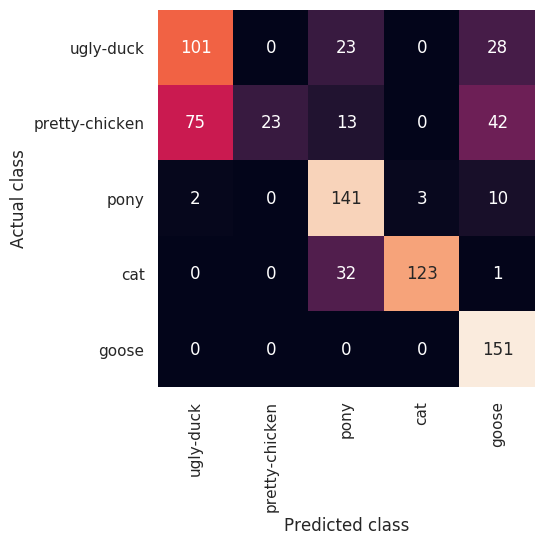

In [0]:
y_pred_named = [test_data.class_labels[x] for x in y_pred]
y_test_named = [test_data.class_labels[x] for x in y_test_]
confusion = confusion_matrix(y_test_named, y_pred_named, labels=test_data.class_labels)

f, ax = plt.subplots(figsize=(5, 5), dpi=100)
ax = sns.heatmap(confusion, annot=True, xticklabels=test_data.class_labels, yticklabels=test_data.class_labels, square=True, cbar=False, fmt="d")
ax.set(xlabel='Predicted class', ylabel='Actual class')
plt.show()

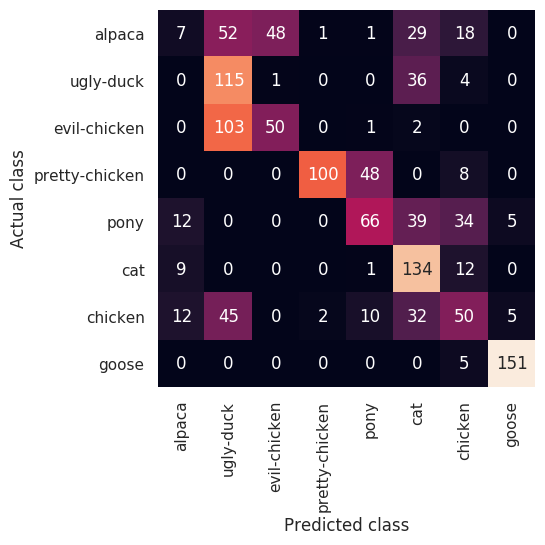

In [0]:
# y_pred = model.predict_classes(X_test)

y_pred_named = [test_data.class_labels[x] for x in y_pred]
y_test_named = [test_data.class_labels[x] for x in y_test_]
confusion = confusion_matrix(y_test_named, y_pred_named, labels=test_data.class_labels)

f, ax = plt.subplots(figsize=(5, 5), dpi=100)
ax = sns.heatmap(confusion, annot=True, xticklabels=test_data.class_labels, yticklabels=test_data.class_labels, square=True, cbar=False, fmt="d")
ax.set(xlabel='Predicted class', ylabel='Actual class')
plt.show()

In [0]:
n = 5

ids = np.random.randint(0, len(X_test)-1, size=n)
print(ids)
preds = np.argmax(model.predict(X_test[ids]), axis=1)

fig, axes = plt.subplots(1, n, figsize=(15, 10))

for id_, ax, pred in zip(ids, axes, preds):
    ax.imshow(X_test[id_][..., 1:])
    ax.axis('off')
    ax.set_title(test_data.class_labels[pred])

plt.tight_layout()

NameError: ignored

[10403  9044 10273 11461  9579]


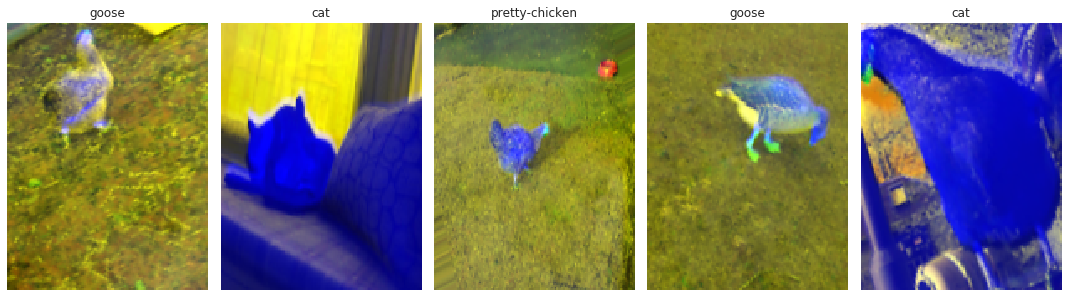

In [0]:
n = 5

ids = np.random.randint(0, len(X)-1, size=n)
print(ids)
preds = np.argmax(model.predict(X[ids, ...]), axis=1)

fig, axes = plt.subplots(1, n, figsize=(15, 10))

for id_, ax, pred in zip(ids, axes, preds):
    ax.imshow(X[id_, ...][..., 1:])
    ax.axis('off')
    ax.set_title(train_data.class_labels[pred])

plt.tight_layout()

In [0]:
asdf = np.random.randint(0, len(train_da))

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])